<a href="https://colab.research.google.com/github/OlaKlingberg/DTSA-5511-M3-Kaggle-CNN-Cancer-Detection/blob/main/DTSA_5511_M4_Disaster_Tweet_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Ola's Notes**



# **1. Imports**

In [1]:
!pip install -q keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install -q tensorflow-text

In [2]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [3]:
!pip install -q --upgrade keras

Here, you must restart the kernel.

In [4]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import pytz
import json

import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold

from sklearn.utils import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt

from keras_nlp.models import DistilBertPreprocessor
from keras_nlp.models import DistilBertClassifier

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, Callback

from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional


Using TensorFlow backend


In [5]:
print(tf.__version__)
print(keras.__version__)
print(keras_nlp.__version__)

2.17.0
0.1.7
0.17.0


# **2. Load the data**

In [6]:
import pandas as pd

# directory = '/content/drive/MyDrive/Colab/Boulder/25. Introduction to Deep Learning/Module 4/data/'
main_dir = '/content/'
data_dir = os.path.join(main_dir, 'data')
results_dir = os.path.join(main_dir, 'results')

results = os.path.join(main_dir, 'results')

df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))



Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# Remove URLs
# df_train['text'] = df_train['text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)

In [10]:
# Remove mentions
# df_train['text'] = df_train['text'].str.replace(r'@\w+', '', regex=True)

In [11]:
# Remove hashtags
# df_train['text'] = df_train['text'].str.replace(r'#\w+', '', regex=True)

In [12]:
# !pip install -q contractions

In [13]:
# # Expand contractions
# import contractions
# df_train['text'] = df_train['text'].apply(lambda x: contractions.fix(x))

In [14]:
# # Handle misspellings
# from textblob import TextBlob
# df_train['text'] = df_train['text'].apply(lambda x: str(TextBlob(x).correct()))

In [15]:
# Clean the tweets (optional, but recommended)
df_train['text'] = df_train['text'].str.replace(r'[^a-zA-Z\s]', '', regex = True).str.lower()

# **3. Exploratory Data Analysis**

In [16]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean       91.858926
std        31.215161
min         3.000000
25%        70.000000
50%        96.000000
75%       120.000000
max       143.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


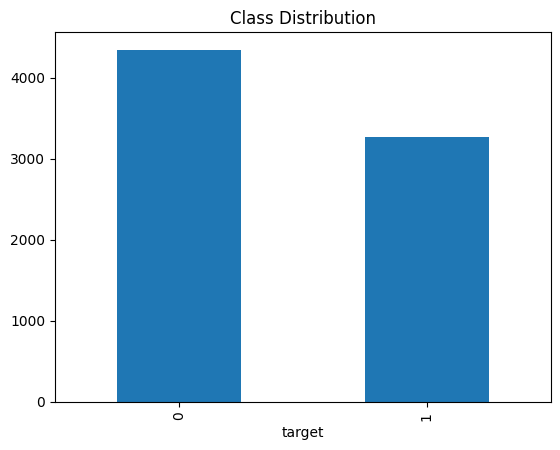

In [17]:
df_train.target.value_counts().plot(kind = 'bar')
plt.title("Class Distribution")
plt.show()

In [18]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes = np.array([0, 1]), y = df_train['target'])

class_weights

# Convert to dictionary format for Keras
# class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

array([0.87666974, 1.1637114 ])

# **4. Split the data**

In [19]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2

from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = VAL_SPLIT, random_state = 42)

X_test = df_test["text"]

In [20]:
# # Using the entire training set, including the validation set, for training
# X_train = X
# y_train = y

# **Utility and Callback functions**

In [21]:
# # Calculate F1 score
# def f1_score(y_true, y_pred):
#     def recall(y_true, y_pred_rounded):
#         true_positives = K.sum(K.cast(y_true * y_pred_rounded, 'float32'))
#         possible_positives = K.sum(K.cast(y_true, 'float32'))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

#     def precision(y_true, y_pred_rounded):
#         true_positives = K.sum(K.cast(y_true * y_pred_rounded, 'float32'))
#         predicted_positives = K.sum(K.cast(y_pred_rounded, 'float32'))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

#     # Check if predictions are logits (2D tensor with shape [batch_size, 2])
#     if K.int_shape(y_pred)[-1] == 2:
#         y_pred = K.argmax(y_pred, axis=-1)  # Convert logits to class predictions

#     y_pred_rounded = K.round(K.clip(y_pred, 0, 1))

#     # LSTM and DistilBert require different casting here
#     try:
#         y_true = K.cast(y_true, 'float32') # Works for the LSTM model

#         precision_val = precision(y_true, y_pred_rounded)
#         recall_val = recall(y_true, y_pred_rounded)
#     except:
#         y_true = K.cast(y_true, 'int64')   # Works for the DistilBert model

#         precision_val = precision(y_true, y_pred_rounded)
#         recall_val = recall(y_true, y_pred_rounded)

#     f1_val = 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))
#     return f1_val

In [22]:
def display_confusion_matrix(y_true, y_pred, dataset, timestamp):
    # Apply threshold to convert probabilities into binary class labels
    y_pred_binary = (y_pred >= 0.5).astype(int)  # Convert probabilities to 0 or 1

    # Create the confusion matrix and display it
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred_binary,  # Use the thresholded predictions
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    f1_score = tp / (tp + ((fn + fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

    # Save the plot with a unique timestamp
    conf_matrix_f = f'conf_matrix_{timestamp}.png'

    # Save the plot
    plt.savefig(os.path.join(results_dir, conf_matrix_f))
    plt.show()

In [52]:
def plot_all_metrics_over_epochs(metrics_history, timestamp):
    epochs = metrics_history.epochs

    plt.figure(figsize=(12, 7))

    # Loss plot
    plt.subplot(2, 3, 1)
    plt.plot(epochs, metrics_history.loss, label='Training Loss')
    plt.plot(epochs, metrics_history.val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 3, 2)
    plt.plot(epochs, metrics_history.accuracy, label='Training Accuracy')
    plt.plot(epochs, metrics_history.val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Precision plot
    plt.subplot(2, 3, 4)
    plt.plot(epochs, metrics_history.precision, label='Training Precision')
    plt.plot(epochs, metrics_history.val_precision, label='Validation Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # Recall plot
    plt.subplot(2, 3, 5)
    plt.plot(epochs, metrics_history.recall, label='Training Recall')
    plt.plot(epochs, metrics_history.val_recall, label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    # F1 plot
    plt.subplot(2, 3, 6)
    plt.plot(epochs, metrics_history.f1, label='Training F1 Score')
    plt.plot(epochs, metrics_history.val_f1, label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.xticks(range(0, max(epochs) + 1, 2))  # Adjust x-ticks to display only whole numbers
    plt.legend()

    plt.tight_layout()

    # Save the plot with a unique timestamp
    metrics_plots_f = f'metric_plots_{timestamp}.png'

    # Save the plot.
    plt.savefig(os.path.join(results_dir, metrics_plots_f))

    plt.show()

# **5. Model 1. LSTM with GloVe embeddings**

In [25]:
# Load GloVe embeddings
embedding_index = {}
with open(os.path.join(data_dir, 'glove.6B.100d.txt'), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors.')

Found 8564 word vectors.


In [26]:
# Prepare the tweets
texts = df_train['text']
max_vocab_size = 10000  # Limit vocab size to top 10,000 words
max_sequence_length = 100  # Max length of each tweet (in tokens)

# Tokenize the text data
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Convert text to sequences of integers and pad
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length)

# Prepare the embedding matrix
embedding_dim = 100  # Using 100-dimensional GloVe vectors
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))

for word, i in word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding_index will be all-zeros
            embedding_matrix[i] = embedding_vector

In [78]:
# Configs
lstm_config = {
    'model': 'lstm',                    # Don't change. To be included when recording the results
    'architecture': 'bidirectional',    # 'one_layer', 'two_layer', or 'bidirectional'
    'first_lstm_layer': 128,            # Number of units in the first LSTM layer
    'second_lstm_layer': 128,           # Number of units in the second LSTM layer
    'dropout': 0.3,                     # Dropout rate to overfitting
    'lr': 0.0001,                       # Learning rate: try 0.001 to 0.00001
    'class_0_weight': 0.7,              # Balanced: class_weights[0]
    'class_1_weight': 1.3,              # Balanced: class_weights[1]
    'batch': 64,                        # Batch size
    'epochs': 15,                       # Number of epochs
    'patience': 3,                      # Early-stopping patience
}

In [79]:
# Define the LSTM model
lstm_model = Sequential()

# Add the embedding layer
lstm_model.add(Embedding(input_dim = max_vocab_size,
                    output_dim = embedding_dim,
                    weights = [embedding_matrix],
                    input_shape = (max_sequence_length,),  # Specify input_shape instead of input_length
                    trainable = False))  # Set trainable=False to use pretrained embeddings

# Add layers based on selected model architecture
if lstm_config['architecture'] == 'one_layer':
    lstm_model.add(LSTM(lstm_config['first_lstm_layer'], return_sequences=False))  # Single LSTM layer
elif lstm_config['architecture'] == 'two_layer':
    lstm_model.add(LSTM(lstm_config['first_lstm_layer'], return_sequences=True))  # First LSTM layer returns full sequence
    lstm_model.add(LSTM(lstm_config['second_lstm_layer'], return_sequences=False))  # Second LSTM layer
elif lstm_config['architecture'] == 'bidirectional':
    lstm_model.add(Bidirectional(LSTM(128)))  # Bidirectional LSTM
else:
    raise ValueError("Invalid model type. Choose from 'one_layer', 'two_layer', or 'bidirectional'.")

# Add the dropout and activation layers.
lstm_model.add(Dropout(lstm_config['dropout'])) # Add a Dropout layer for regularization
lstm_model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate = lstm_config['lr'])

# Compile
lstm_model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
            #   metrics = ['accuracy', f1_score, Precision(), Recall()])
              metrics = ['accuracy', Precision(), Recall()])

# Summary of the model
lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,234,753 (4.71 MB)

 Trainable params: 234,753 (917.00 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [80]:
%%time
# Train the model

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = lstm_config['patience'], restore_best_weights = True)

# Metrics history, to enable plotting precision and recall
class MetricsHistory(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = []
        self.loss = []
        self.accuracy = []
        self.precision = []
        self.recall = []
        self.f1 = []
        self.val_loss = []
        self.val_accuracy = []
        self.val_precision = []
        self.val_recall = []
        self.val_f1 = []

    def on_epoch_end(self, epoch, logs=None):
        # print()
        # print("Available logs:", logs.keys())  # Print available keys for debugging
        # print()
        self.epochs.append(epoch)
        self.loss.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        # self.f1_score.append(logs.get('f1_score'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        # self.val_f1_score.append(logs.get('val_f1_score'))

        # The precision keys increment: precision_1, precision_2, etc.
        # Dynamically find keys containing 'precision'.
        precision_keys = [key for key in logs.keys() if 'precision' in key]
        recall_keys = [key for key in logs.keys() if 'recall' in key]
        if precision_keys:
            precision = logs.get(precision_keys[0]) # first precision key found
            self.precision.append(precision)
        if recall_keys:
            recall = logs.get(recall_keys[0]) # first recall key found
            self.recall.append(recall)

        # The recall keys increment: recall_1, recall_2, etc.
        # Dynamically find keys containing 'recall'.
        val_precision_keys = [key for key in logs.keys() if 'val_precision' in key]
        val_recall_keys = [key for key in logs.keys() if 'val_recall' in key]
        if val_precision_keys:
            val_precision = logs.get(val_precision_keys[0])
            self.val_precision.append(val_precision)
        if val_recall_keys:
            val_recall = logs.get(val_recall_keys[0])
            self.val_recall.append(val_recall)

        # Calculate f1 score and store
        f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        self.f1.append(f1)

        # Calculate val_f1 score and store
        val_f1 = 2 * ((val_precision * val_recall) / (val_precision + val_recall + K.epsilon()))
        self.val_f1.append(val_f1)

# Instantiate the custom callback
metrics_history = MetricsHistory()

# Convert to NumPy array
if isinstance(y_train, pd.Series):
    y_train = y_train.values

# Create dictionary with class weights
class_weights_dict = {0: lstm_config['class_0_weight'], 1: lstm_config['class_1_weight']}

# Train the model with early stopping
lstm_history = lstm_model.fit(X_train_padded, y_train,
                              class_weight = class_weights_dict,
                              epochs = lstm_config['epochs'],
                              batch_size = lstm_config['batch'],
                              validation_data=(X_val_padded, y_val),
                              callbacks=[metrics_history, early_stopping])


Epoch 1/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4977 - loss: 0.6334 - precision_8: 0.4509 - recall_8: 0.8130 - val_accuracy: 0.6395 - val_loss: 0.6050 - val_precision_8: 0.5479 - val_recall_8: 0.8814
Epoch 2/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6801 - loss: 0.5114 - precision_8: 0.5888 - recall_8: 0.8282 - val_accuracy: 0.7262 - val_loss: 0.5507 - val_precision_8: 0.6355 - val_recall_8: 0.8382
Epoch 3/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7337 - loss: 0.4834 - precision_8: 0.6544 - recall_8: 0.7890 - val_accuracy: 0.7459 - val_loss: 0.5358 - val_precision_8: 0.6613 - val_recall_8: 0.8274
Epoch 4/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7498 - loss: 0.4641 - precision_8: 0.6836 - recall_8: 0.7841 - val_accuracy: 0.7899 - val_loss: 0.4890 - val_precision_8: 0.7496 - val_recall_8: 0.7612
Epoch 5/15
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7569 - loss: 0.4580 - precision_8: 0.6996 - recall_8: 0.7744 - val_

In [81]:
# Evaluate the model on the validation set
val_loss, val_acc, val_precision, val_recall = lstm_model.evaluate(X_val_padded, y_val, verbose = 2)

# Calculate f1
val_f1 = 2 * ((val_precision * val_recall) / (val_precision + val_recall + K.epsilon()))

# Output results
print(f"Validation Accuracy: {round(val_acc, 3)}")
print(f"Validation Loss: {round(val_loss, 3)}")
print(f"Validation F1 score: {round(val_f1, 3)}")
print(f"Validation Precision: {round(val_precision, 3)}")
print(f"Validation Recall: {round(val_recall, 3)}")

48/48 - 0s - 5ms/step - accuracy: 0.7912 - loss: 0.4767 - precision_8: 0.7582 - recall_8: 0.7488
Validation Accuracy: 0.791
Validation Loss: 0.477
Validation F1 score: 0.753
Validation Precision: 0.758
Validation Recall: 0.749


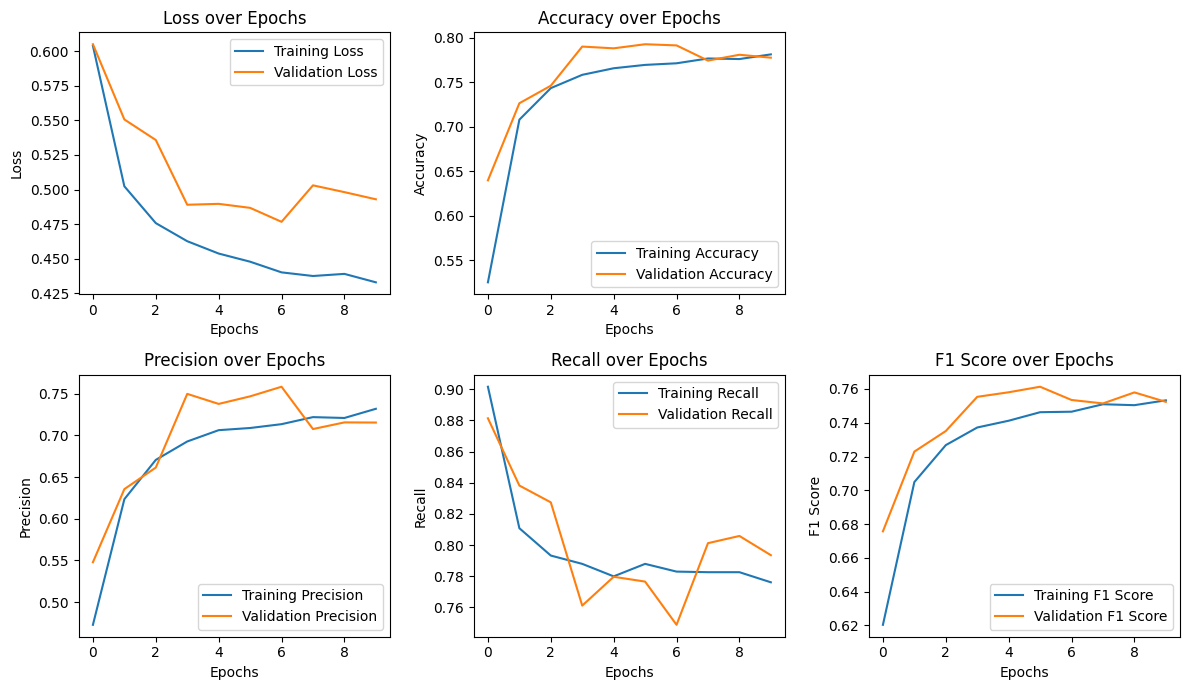

In [82]:
# Generate a timestamp, to be used in the file names of all generated files
timestamp = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H%M')

# Create a new dictionary, to hold both configs and final validation results
config_and_results = lstm_config.copy()

# Add final validation values to the dictionary
config_and_results['val_acc'] = val_acc
config_and_results['val_loss'] = val_loss
config_and_results['val_precision'] = val_precision
config_and_results['val_recall'] = val_recall
config_and_results['val_f1'] = val_f1

# File name for the config_and_results file
config_and_results_f = f'config_and_results_{timestamp}.json'

# Generate a JSON object with the configs and the results.
with open(os.path.join(results_dir, config_and_results_f), 'w') as f:
    json.dump(config_and_results, f, indent = 4)

# Plot metrics over epochs
plot_all_metrics_over_epochs(metrics_history, timestamp)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


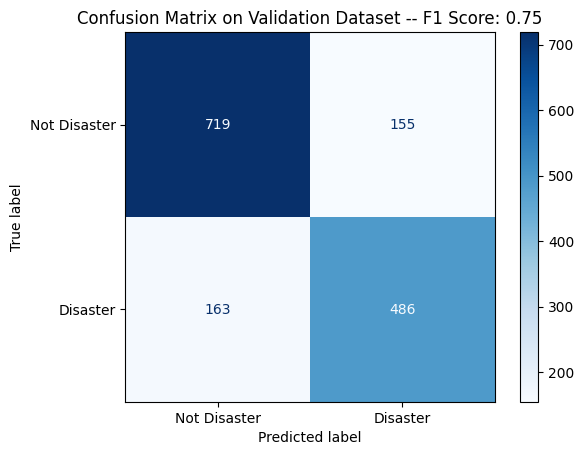

In [83]:
y_pred_val = lstm_model.predict(X_val_padded)

display_confusion_matrix(y_val, y_pred_val, "Validation", timestamp)

1

# **6. Model 2. DistilBERT**

In [227]:
# Configs
bert_config = {
    'model': 'distilbert',
    'lr': 0.00002, # Start around 0.00002 to 0.00005
    'epochs': 3,
    'patience': 3,
    'batch': 32 # Try 16, 32, 64.
}

In [228]:
AUTO = tf.data.experimental.AUTOTUNE

In [281]:
%%time
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = DistilBertPreprocessor.from_preset(preset,
                                                  sequence_length = 160,
                                                  name = "preprocessor_4_tweets")

# Pretrained classifier.
bert_model = DistilBertClassifier.from_preset(preset,
                                              preprocessor = preprocessor,
                                              num_classes = 2)

bert_model.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_4 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_4[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 1.28 s, sys: 78.5 ms, total: 1.36 s
Wall time: 9.24 s


In [283]:
# Compile
bert_model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), #'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate = bert_config['lr']),
    metrics= ["accuracy", f1_score]
)


In [284]:
%%time
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience = bert_config['patience'], restore_best_weights = True)


# Add class weights!



# Fit
bert_history = bert_model.fit(x = X_train,
                              y = y_train,
                              batch_size = bert_config['batch'],
                              epochs = bert_config['epochs'],
                              validation_data = (X_val, y_val),
                              callbacks = [early_stopping])

Epoch 1/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 86s 263ms/step - accuracy: 0.7266 - f1_score: 0.6467 - loss: 0.5337 - val_accuracy: 0.8411 - val_f1_score: 0.7950 - val_loss: 0.3869
Epoch 2/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8537 - f1_score: 0.8109 - loss: 0.3569 - val_accuracy: 0.8418 - val_f1_score: 0.7986 - val_loss: 0.3898
Epoch 3/3
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.8877 - f1_score: 0.8560 - loss: 0.2916 - val_accuracy: 0.8306 - val_f1_score: 0.7759 - val_loss: 0.4092
CPU times: user 2min 28s, sys: 2.37 s, total: 2min 30s
Wall time: 2min 10s


In [285]:
# Evaluate the model on the validation set
val_loss, val_acc, val_f1 = lstm_model.evaluate(X_val_padded, y_val, verbose = 2)
print(f"Validation Accuracy: {round(val_acc, 3)}")
print(f"Validation Loss: {round(val_loss, 3)}")
print(f"Validation F1 score: {round(val_f1, 3)}")

48/48 - 0s - 3ms/step - accuracy: 0.8168 - f1_score: 0.7580 - loss: 0.4202
Validation Accuracy: 0.817
Validation Loss: 0.42
Validation F1 score: 0.758


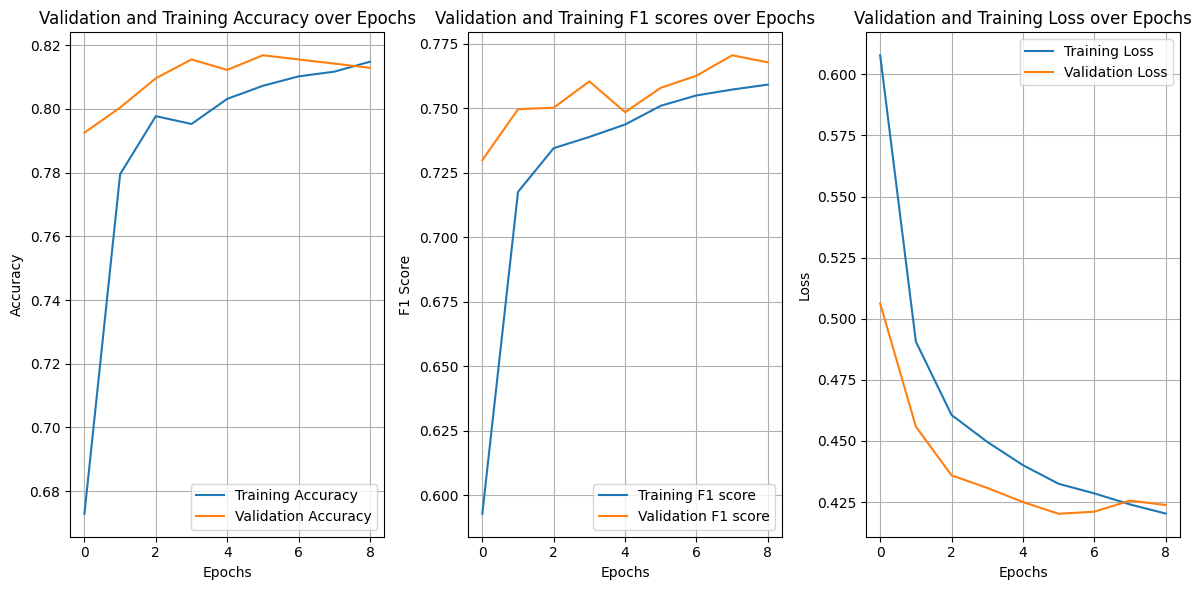

In [296]:
# Generate a timestamp, to be used in the file names of all generated files
timestamp = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H%M')

# Create a new dictionary, to hold both configs and final validation results
config_and_results = bert_config.copy()

# Add final validation values to the dictionary
config_and_results['val_acc'] = val_acc
config_and_results['val_loss'] = val_loss
config_and_results['val_f1'] = val_f1

# File name for the config_and_results file
config_and_results_f = f'config_and_results_{timestamp}.json'

# Generate a JSON object with the configs and the results.
with open(os.path.join(results_dir, config_and_results_f), 'w') as f:
    json.dump(config_and_results, f, indent = 4)

# Plot metrics over epochs
plot_metrics_over_epochs(lstm_history, timestamp)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


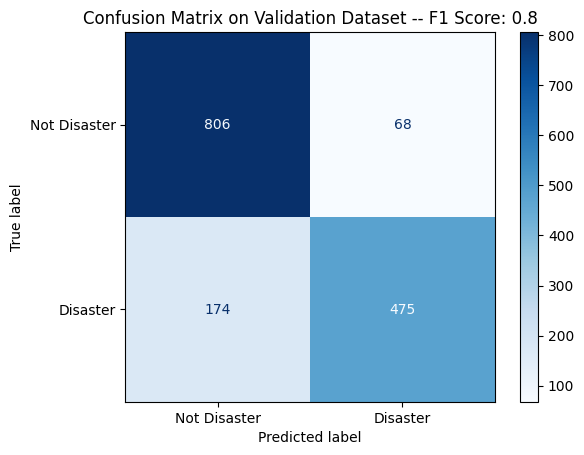

In [301]:
y_pred_val = bert_model.predict(X_val)

display_confusion_matrix(y_val, y_pred_val, "Validation")

# **Gather the configs and results for all models so far in a dataframe**

To make it easy to see how the hyper-parameter tuning affects the results, we will gather the data from configs_and_results from all runs so far into a single dataframe.

In [243]:
# List to store each run's data
all_runs_data = []

# Loop through each file in the base directory
for file in os.listdir(results_dir):
    json_file_path = os.path.join(results_dir, file)

    # Only proceed if it's a JSON file that starts with "config_and_results"
    if file.startswith("config_and_results") and file.endswith(".json"):
        # Extract the date and time part from the file name
        date_time_part = file.replace("config_and_results_", "").replace(".json", "")

        # Read the JSON file
        with open(json_file_path, 'r') as json_file:
            config_and_results = json.load(json_file)
            config_and_results['date_time'] = date_time_part  # Add the date and time to the data
            all_runs_data.append(config_and_results)

# Convert the list of dictionaries into a Pandas DataFrame
all_runs_summary = pd.DataFrame(all_runs_data)

all_runs_summary = all_runs_summary.fillna("")

# Put the columns in order
col_order = ['date_time', 'model', 'architecture', 'first_lstm_layer', 'second_lstm_layer', \
             'dropout', 'epochs', 'patience', 'lr', 'val_loss', 'val_acc', 'val_f1']
all_runs_summary = all_runs_summary[col_order]

# Sort dataframe by data_tiem
all_runs_summary.sort_values(by = 'date_time', inplace = True)

# File name for the summary file
all_runs_summary_f = f'all_runs_summary_{timestamp}.csv'

# Save the dataframe to a CSV file
all_runs_summary.to_csv(os.path.join(results_dir, all_runs_summary_f), index = False)

In [240]:
all_runs_summary

,date_time,model,architecture,first_lstm_layer,second_lstm_layer,dropout,epochs,patience,lr,val_loss,val_acc,val_f1
0,2024-10-23_1914,lstm,one_layer,128.0,64.0,0.5,3,3,0.00010,0.442822,0.805647,0.731672
1,2024-10-23_1916,distilbert,,,,,3,3,0.00002,0.442822,0.805647,0.731672


# **8. Generate Submission File**

In [236]:
# # Generate predictions
# test_pred = np.argmax(classifier.predict(X_test), axis = 1)

# # Get the test_ids from the test data
# test_ids = df_test["id"]

# # Create a DataFrame
# submission_df = pd.DataFrame({
#     'id': test_ids,
#     'target': test_pred
# })

# # Optional: Check the DataFrame to ensure it looks correct
# print(submission_df.head())

# # Save the DataFrame to a CSV file
# submission_df.to_csv(directory + 'submission.csv', index = False)